## CCD Camera Experimentation 

The purpose of this experiment was to measure and better understand the properties of equipment used at the Mt. Stony Brook Observatory. We took both photometric and spectroscopic data sets in hopes to analyze, calibrate, and conceptualize the obervatory setup, process, data, as well as the equipment. 

Import statements for various functions and tasks

In [162]:
#efficient/fast mathematical operator library
import numpy as np
#import from astropy lib -- used to manipulate fits files 
from astropy.io import fits
#plotting functions
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from IPython.display import clear_output 
#used to import files from system --> Jupyter 
import os
#used to manipulate csv file 
import pandas as pd
from scipy.signal import find_peaks

Below are various (universal/reusable) functions that are used throughout the lab to optimize/minimize code. 

In [163]:
#Universal Functions used throughout Code  

#Automatically Shape Array
def fits_data_to_3d_array(file_list): 
    for i, file in enumerate(file_list):
        with fits.open(file) as hdu:
            if i==0:  #If first iteration, create array with correct shape of data
                final_array = np.zeros((len(file_list), *hdu[0].data.shape))
            final_array[i,:,:] = hdu[0].data
    return final_array

#takes in a 3d array from the above function, median combines.
def median_combine(frame_array_3d):
    master_frame = np.median(frame_array_3d,axis=0) #takes median along the 'file_index' axis
    return master_frame

def mean_combine(frame_array_3d):
    master_frame = np.mean(frame_array_3d,axis=0) #takes median along the 'file_index' axis
    return master_frame
    
#Takes in a 2d array, saves as a fits file for viewing in ds9
def save_array_as_fits(array, new_file_name):
    hdu = fits.PrimaryHDU(data = array)
    hdul = fits.HDUList([hdu])
    hdul.writeto(new_file_name)

# New File List Function
def create_file_list(data_directory, file_name, frame_type, num_of_files, show_list = False):   
    '''
    This creates a list of all FITS files that will be used.
    
    Parameters:
    data_directory : path to data folder
    file_name : name of file containing data (ex.: spectrograph_flats_20s_)
                Remove anything that comes after the number!
    frame_type : type of frame saved (ex.: .FLAT, .DARK, .BIAS)
    num_of_files : number of files (must be below 11)
    '''  
    file_list = [os.path.join(data_directory, file_name + f'.0000000{i}' + frame_type + '.FIT') for i in range(num_of_files)]  
    if show_list: 
        for file in file_list: print(file)   
    return file_list
#File creation function 
def create_file_list_2(folder_path):
    files = [f for f in os.listdir(folder_path) if f.startswith('dark_frame_') and f.endswith('.DARK.FIT')]
    file_list = [os.path.join(folder_path, f) for f in files]
    exposure_times = [float(f.split('_')[2].replace('s', '')) for f in files]
    return file_list, exposure_times

# function to cut 2d arrays of images 
def cut_images_array(image_array, y_pixel_min, y_pixel_max):
    lower_index = (-1) + y_pixel_min
    upper_index = (-1) + y_pixel_max
    image_array_cut = image_array[lower_index:upper_index,:]
    print(image_array_cut.shape)
    return image_array_cut

#used mainly to display 2D arrays of the Flat-Field images 
def display_2d_array(image_array, lower_percentile=1, upper_percentile=99):
    minimum = np.percentile(image_array,lower_percentile)
    maximum = np.percentile(image_array,upper_percentile)
    plt.imshow(image_array, cmap='gray', origin = 'lower', vmin=minimum, vmax=maximum)
    plt.colorbar(location='top')

### 4.1: Bias Frames

4.1 is divided into 2 sub section. 4.1.1, begins with bias frames. These frames are zero exposure images, which measure statistical electric noise from the camera, which we can use to correct in our final image for better results. We hope to analyze the bias frame counts and their distribution. The counts in the Bias frames tell us the readout noise resulting from the CCD camera's electronics. The camera can sometimes also contain specific pixels which register abnormal or irregular count values due to sensor issues/malfunctions, which we classify as hot pixels. By plotting and optimizing the distribution we can hope to cut out a certain fraction of hot pixels in order to achieve a more efficient readout noise, which allows for better correction of our final image. In 4.2.2, we adapt a gaussian distribution of the Bias Frames counts through the manipulation of the number of counts to obtain gaussian mean and STDEV. We can also calculate the gain [comparison of electrons to the cameras anolog-->digital conversion range] of the camera, by converting the final read out noise into electron units. We hope to obtain a gain value close to the one listed in the CCD Camera manual. The purpose of 4.1 is to use our observationally obtained bias frames to calculate count and gain values, and calibrate them such that we obtain known values from the CCD Camera. 

In [164]:
#Functions and Files used in 4.1

#A normal distribution, scaled by a constant factor to fit a gaussian distribution to a non-normalized function.
def scaled_normal_dist(x, a, mean, stdev):
    return a * np.exp(-(x-mean)**2/(2.0*stdev**2)) / np.sqrt(2.0*np.pi*stdev**2)

#returns a 1d list without entries outside the bounds
def cut_1d_list(list_to_cut,bounds): 
    cut_list = []
    for x in list_to_cut:
        if bias_cut_range[0] < x < bias_cut_range[1]:
            cut_list.append(x)
    return cut_list



#The three 0C bias fits files
bias_files = [r"C:\Users\ronan\Group 2 Data\Group 2 Data\Photometry\bias_frames_at_different_temperatures\bias_frame_at_0C_.00000010.BIAS.FIT",
              r"C:\Users\ronan\Group 2 Data\Group 2 Data\Photometry\bias_frames_at_different_temperatures\bias_frame_at_0C_.00000011.BIAS.FIT",
              r"C:\Users\ronan\Group 2 Data\Group 2 Data\Photometry\bias_frames_at_different_temperatures\bias_frame_at_0C_.00000012.BIAS.FIT"]

(800.0, 1200.0)

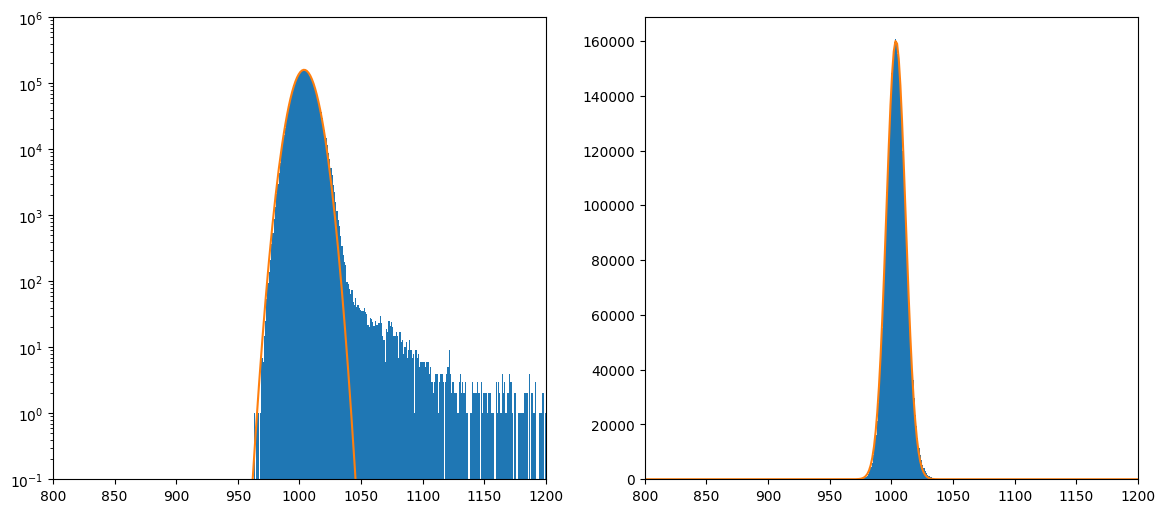

In [165]:
#Create and graph the bias histogram + fit

bias_cut_range = [500,1500] #defines what count range the fit to the histogram is based on
display_range = [800,1200] #defines the count range to show on the main graphs
cut_bias_counts_list = cut_1d_list(fits_data_to_3d_array(bias_files).flatten(),bias_cut_range)
n_bins = 1000 #number of histogram bins to create in the cut range

#histogram of the cut list
cut_bias_hist = np.histogram(np.array(cut_bias_counts_list),n_bins,bias_cut_range) 
#create the gaussian fit to the histogram
bias_popt, bias_pcov = curve_fit(scaled_normal_dist,xdata=cut_bias_hist[1][:-1]+.5*(cut_bias_hist[1][1]-cut_bias_hist[1][0]),
                                 ydata=cut_bias_hist[0],p0=[20,1000,20]) 
#plotting of the histogram and fit as well. 
fig, ax = plt.subplots(ncols=2,figsize=(14,6))
ax[0].hist(fits_data_to_3d_array(bias_files).flatten(),n_bins,bias_cut_range)
ax[1].hist(fits_data_to_3d_array(bias_files).flatten(),n_bins,bias_cut_range)
xs = np.linspace(display_range[0],display_range[1],300)
ax[0].plot(xs,scaled_normal_dist(xs, *bias_popt))
ax[0].set_ylim(.1,1e6)
ax[0].set_yscale('log')
ax[1].plot(xs,scaled_normal_dist(xs, *bias_popt))
ax[1].set_xlim(display_range[0],display_range[1])
ax[0].set_xlim(display_range[0],display_range[1])

In [166]:
#Identify hot pixels as those not used in fit, which can be found by varying the graphs above:
counts_list_length = len(fits_data_to_3d_array(bias_files).flatten())
n_hot_pixels = counts_list_length-len(cut_bias_counts_list)

print(f"There are {n_hot_pixels} total identified hot pixels across 3 files, a fraction of {n_hot_pixels/counts_list_length:.7f} of the total.")

There are 26 total identified hot pixels across 3 files, a fraction of 0.0000083 of the total.


In [167]:
#This block prints the headers of one of the bias fits files.
#According to the CCD datasheet, gain = 2., readout noise 14.8e- RMS. Gain agrees to within 3% with header
with fits.open(r"C:\Users\ronan\Group 2 Data\Group 2 Data\Photometry\bias_frames_at_different_temperatures\bias_frame_at_0C_.00000010.BIAS.FIT") as hdu:
            print(hdu[0].header)

print('\n', f"The readout noise from our data is {2.06*7.80:.1f} e-, which is {100.*(2.06*7.80-14.8)/(14.8):.2f}% away from the datasheet value.")

SIMPLE  =                    T/CCDSOFT-SOFTWARE BISQUE 3                        BITPIX  =                   16                                                  NAXIS   =                    2                                                  NAXIS1  =                 1024                                                  NAXIS2  =                 1024                                                  BSCALE  = +1.000000000000E+000                                                  BZERO   = +3.276800000000E+004                                                  BIAS    =                  100                                                  FOCALLEN= +0.000000000000E+000                                                  APTAREA = +0.000000000000E+000                                                  APTDIA  = +0.000000000000E+000                                                  DATE-OBS= '2024-08-30T01:57:32.328'                                             TIME-OBS= '01:57:32.328        '        

As seen above, we measured a total of 26 identifiable hot pixels across our 3 bias frames at 0°C, which is a fraction of 0.0000083 of the total counts. This is a very tiny fraction in comparison to the total counts, but by removing them from our distribution, we can see the drastic affects it has on our distribution and fit. As visible by the header display of theCCD Camera above, our readout noise of 16.1 e-, is 8.57% away from the header value. 

### 4.2.1

4.2, split into 2 subsections again, Focuses on our Dark frames. Dark frames are the read out noise given at certain exposure times while the shutter is still closed(compares to bias frames which are 0 exposure time measures). They are also heavily temperature dependant as dark current increases with T. Dark current is defined as the electrical current flowing through our sensors which are easily influenced by thermal fluctuations. In 4.2.1, we take 10 of our dark frames and calculate the median combine to obtain one "Master" dark frame. [We got this combine by stacking all 10 of our images and finding median pixel value at each location, our new image or master dark frame are constituted by each median pixel. This helps to preserve quality and reduce noise when compared to other statistical methods such as averaging the frames as the median is also less affected by outliers.] Similar to the bias frames we need to identify any hot pixels in the master dark frame. However because we are taking a dark frame combine their may be two main types of hot pixels. Permanents and transients: Permanent hot pixels are pixels that register irregularly high counts along all images, where as transient hot pixels are hot in some images and not others. Transients can arise from thermal fluctuations in some images or even instantaneous cosmic ray impacts against the sensor. We hope to again correct our master dark frame and produce a gaussian-like distribution of the counts of the master frame so it can be suitable for subtraction from any observational images. 

In [168]:
#creates the list of FITS files for the .3s dark frames
#"C:\Users\ronan\Group 2 Data\Group 2 Data\Photometry\dark_frames_at_.3s_exposure\dark_0.3s_exposure_.00000000.DARK.FIT"
dark_file_list = create_file_list(data_directory = r"C:\Users\ronan\Group 2 Data\Group 2 Data\Photometry\dark_frames_at_.3s_exposure", 
                 file_name = 'dark_0.3s_exposure_', 
                 frame_type = '.DARK', 
                 num_of_files = 10,
                 show_list=True)

C:\Users\ronan\Group 2 Data\Group 2 Data\Photometry\dark_frames_at_.3s_exposure\dark_0.3s_exposure_.00000000.DARK.FIT
C:\Users\ronan\Group 2 Data\Group 2 Data\Photometry\dark_frames_at_.3s_exposure\dark_0.3s_exposure_.00000001.DARK.FIT
C:\Users\ronan\Group 2 Data\Group 2 Data\Photometry\dark_frames_at_.3s_exposure\dark_0.3s_exposure_.00000002.DARK.FIT
C:\Users\ronan\Group 2 Data\Group 2 Data\Photometry\dark_frames_at_.3s_exposure\dark_0.3s_exposure_.00000003.DARK.FIT
C:\Users\ronan\Group 2 Data\Group 2 Data\Photometry\dark_frames_at_.3s_exposure\dark_0.3s_exposure_.00000004.DARK.FIT
C:\Users\ronan\Group 2 Data\Group 2 Data\Photometry\dark_frames_at_.3s_exposure\dark_0.3s_exposure_.00000005.DARK.FIT
C:\Users\ronan\Group 2 Data\Group 2 Data\Photometry\dark_frames_at_.3s_exposure\dark_0.3s_exposure_.00000006.DARK.FIT
C:\Users\ronan\Group 2 Data\Group 2 Data\Photometry\dark_frames_at_.3s_exposure\dark_0.3s_exposure_.00000007.DARK.FIT
C:\Users\ronan\Group 2 Data\Group 2 Data\Photometry\dark

In [169]:
#Performs a median combine to get a master dark frame:
dark_array_3d = fits_data_to_3d_array(dark_file_list)
#universal function median_combine defined in universals. 
master_dark_frame = median_combine(dark_array_3d)
#Save as fits to view on ds9
#save_array_as_fits(master_dark_frame, "master_dark_frame.FITS")

(array([0.00000e+00, 0.00000e+00, 0.00000e+00, 2.00000e+00, 6.00000e+00,
        1.30000e+01, 6.20000e+01, 1.36000e+02, 4.24000e+02, 1.06400e+03,
        2.73800e+03, 6.32600e+03, 1.38390e+04, 2.90900e+04, 5.50630e+04,
        1.00816e+05, 1.67773e+05, 2.66642e+05, 3.86529e+05, 5.33911e+05,
        6.81314e+05, 8.24419e+05, 9.31490e+05, 9.92465e+05, 9.92742e+05,
        9.40628e+05, 8.43573e+05, 7.14405e+05, 5.78967e+05, 4.42266e+05,
        3.28769e+05, 2.28194e+05, 1.57076e+05, 1.00758e+05, 6.46390e+04,
        3.88490e+04, 2.34090e+04, 1.31270e+04, 7.64800e+03, 5.65100e+03]),
 array([ 960.,  962.,  964.,  966.,  968.,  970.,  972.,  974.,  976.,
         978.,  980.,  982.,  984.,  986.,  988.,  990.,  992.,  994.,
         996.,  998., 1000., 1002., 1004., 1006., 1008., 1010., 1012.,
        1014., 1016., 1018., 1020., 1022., 1024., 1026., 1028., 1030.,
        1032., 1034., 1036., 1038., 1040.]),
 <BarContainer object of 40 artists>)

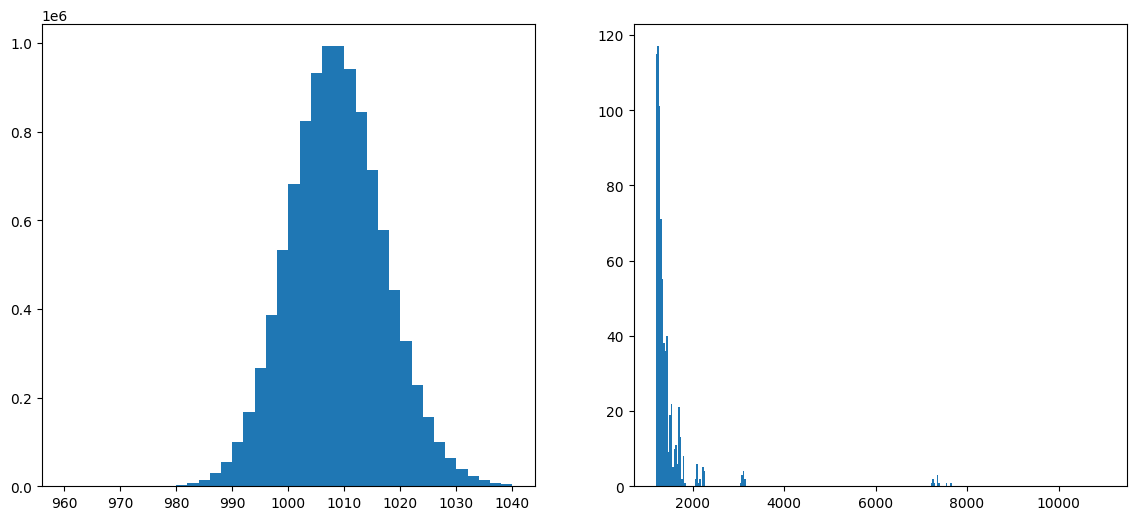

In [170]:
#Identifying Hot Pixels: plot a main histogram and a secondary histogram to see hot pixels
flattened_dark_array = dark_array_3d.flatten()
fig, ax = plt.subplots(ncols=2,figsize=(14,6))
ax[1].hist(flattened_dark_array,300,[1200,11000])
ax[0].hist(flattened_dark_array,40,[960,1040])

In [171]:
#Threshold used: 2000 counts

#The following creates an array (with the same shape as the input) filled with zeros except for the
#pixels that are above the threshhold - they are given a value equal to 1.
hot_pixel_array = np.where(dark_array_3d > 2000,
                           np.ones((len(dark_array_3d[0,:,0]),len(dark_array_3d[0,0,:]))),
                           np.zeros((len(dark_array_3d[0,:,0]),len(dark_array_3d[0,0,:]))))
#np.savetxt("hot_pixel_array.csv", hot_pixel_array, delimiter=",", fmt='%d') #For manual viewing
print('Number of hot pixels across all dark frames: ', np.sum(hot_pixel_array))

#sums the 3d hot pixel array over the file index to see if the identified hot pixels are "hot" for all images. 
hot_pixel_rows_summed = np.sum(hot_pixel_array, axis=0)
print('Number of hot pixels: ', np.sum(hot_pixel_rows_summed)) #Double check sum
#np.savetxt("hot_pixel_rows_summed.csv", hot_pixel_rows_summed, delimiter=",", fmt='%d')

Number of hot pixels across all dark frames:  50.0
Number of hot pixels:  50.0


In [172]:
#Gauge Middle Value for Counts, and other statistics
median = np.median(dark_array_3d)
mean = dark_array_3d.mean()
minimum = np.min(dark_array_3d)
maximum = np.max(dark_array_3d)
print('median: ', median, 'mean: ', mean, 'min: ', minimum, 'max: ', maximum)
max_index = np.argmax(dark_array_3d)
print(max_index)

median:  1008.0 mean:  1008.3034660339356 min:  967.0 max:  18372.0
1046559


After performing our median combine of the 10 dark frames at .3 exposure and0°C, we plot 2 different graphs; one with the hot pixels and overall distribution. And another corrected image with a gaussian distribution after removing the hot pixels and specifying a smaller range. After calculating the number of hot pixels, we can see that there are 50 hot pixels across the dark frames, and 50 in the master dark frame. Showing that in our instance of observations, we observed no transient hot pixels in our images. So we only have to correct for the permanents due to malfunction or imperfections of the CCD Camera. We also provide the statistics of the overall counts and values, which prove our gaussian distribution as well as give us a look at the average count values we are observing in the CCD for the dark frames. 

## 4.2.2

in 4.2.2, we will measure the mean and standard deviation of each dark frame across all exposure times to obtain the systematic as well as statistical uncertainties of the dark frames prior to median combine. This will give us the information of the counts and the affect of exposure time on these values, we can represent this graphically by plotting the means per each exposure time against the exposure times in the time series. We can perform a linear regression on this to mathematically derive the relationship between the two and verify if their is any linearity between the two. We will also check the residuals by plotting against the exposure times. The residuals give us the difference in expected and observed values, showing how far of the regression is from each data point. We expect higher uncertainties with the residuals as exposure time increases due to the increase noise and signal outputs which increases count values and therefore higher associated uncertanties. We will also calculate the dark current from our corrected dark frames (correction comes from subtracting the bias frames) per exposure time. We hope to obtain a small dark current as we have corrected our dark frames through bias subtraction so there should be higher signal-noise ration which is correspondent to a lower dark current (we want more signal than noise so the ratio should be high when comparing signal to noise). The time series of increased exposure times should also assist in lowering the dark value current, however due to the gain of the CCD Camera it will double the expected dark current values. 

In [173]:
# Define folder path and file naming pattern
folder_path = r"C:\Users\ronan\Group 2 Data\Group 2 Data\Photometry\dark_frames_at_different_exposure_times"
# Paths to bias frames
bias_at_15C = [r"C:\Users\ronan\Group 2 Data\Group 2 Data\Photometry\bias_and_dark_at_15C\bias_at_15C_.00000000.BIAS.FIT"]
dark_at_15C = [r"C:\Users\ronan\Group 2 Data\Group 2 Data\Photometry\bias_and_dark_at_15C\dark_at_15C_.00000000.DARK.FIT"]
bias_frame_paths = [
    r"C:\Users\ronan\Group 2 Data\Group 2 Data\Photometry\bias_frames_at_different_temperatures\bias_frame_at_0C_.00000010.BIAS.FIT",
    r"C:\Users\ronan\Group 2 Data\Group 2 Data\Photometry\bias_frames_at_different_temperatures\bias_frame_at_0C_.00000011.BIAS.FIT",
    r"C:\Users\ronan\Group 2 Data\Group 2 Data\Photometry\bias_frames_at_different_temperatures\bias_frame_at_0C_.00000012.BIAS.FIT"
]

Generates a list of filenames in the directory that match the pattern dark_frame_*.DARK.FIT, creates a path, and extracts the exposure times as floats for calculations, and returns file paths and exp times.

In [174]:
#pixel data/conversion
def load_dark_frames(file_list):
    pixel_counts_list = []
    for file in file_list:
        if os.path.isfile(file):
            try:
                with fits.open(file) as hdu:
                    pixel_counts_list.append(hdu[0].data.flatten())
            except Exception as e:
                print(f"Error loading file {file}: {e}")
        else:
            print(f"File not found: {file}")
    return np.array(pixel_counts_list)

Stores pixel data for each dark frame and flattens it into a 1D array and returns them as a Numpy array

In [175]:
# calculates mean count, stdv, and uncertainty
def calculate_statistics(frames, low_limit, high_limit):
    if low_limit and high_limit:
        limited_frames = np.where((frames > low_limit) & (frames < high_limit), frames, np.nan)
        mean_limited = np.nanmean(limited_frames, axis=1)
        systematic_uncertainty = np.std(mean_limited)
        return mean_limited, systematic_uncertainty 
    else: 
        means = np.mean(frames, axis=1)
        std_devs = np.std(frames, axis=1)
        uncertainties = std_devs / np.sqrt(frames.shape[1])
        min= np.min(frames)
        max= np.max(frames)
        return means, uncertainties, min, max

function calculates mean count values of frames per pixel and the associated standard deviation. As well as the uncertainty (both statistical and systematic) using the stdv and #of frames.

In [176]:
#linear regression calculations
def linear_fit(x, slope, intercept):
    return slope * x + intercept

def perform_linear_regression(x, y, yerr):
    popt, pcov = curve_fit(linear_fit, x, y, sigma=yerr, absolute_sigma=True)
    return popt, np.sqrt(np.diag(pcov))

linear fit defines a function for "fitting" with parameters of x, slope, and intercept. perform_linear_regrssion fits the function to our data using exposure times (x) , mean count (y) , and uncertainties (yerr). Returns optimized parameters and standard error

In [177]:
#plotting 
def plot_mean_vs_exposure(exposure_times, means, uncertainties, slope, intercept):
    plt.errorbar(exposure_times, means, yerr=uncertainties, fmt='o', label='Data')
    plt.plot(exposure_times, linear_fit(np.array(exposure_times), slope, intercept), 'r-', label=f'Fit: y = {slope:.2f}x + {intercept:.2f}')
    plt.xlabel('Exposure Time (s)')
    plt.ylabel('Mean Counts')
    plt.legend()
    plt.show()

def plot_residuals(exposure_times, means, uncertainties, slope, intercept):
    fit_line = linear_fit(np.array(exposure_times), slope, intercept)
    residuals = np.array(means) - fit_line
    plt.errorbar(exposure_times, residuals, yerr=uncertainties, fmt='o', label='Residuals')
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Exposure Time (s)')
    plt.ylabel('Residuals')
    plt.legend()
    plt.show()

This cell block contains the plotting of both the relationship between mean counts vs. exposure times as well the residuals (with uncertainties) of data points.

In [178]:
# Function to calculate the mean of bias frames
def calculate_bias_mean(bias_paths):
    bias_means = []
    for path in bias_paths:
        try:
            with fits.open(path) as hdul:
                data = hdul[0].data
                bias_means.append(np.mean(data))
        except Exception as e:
            print(f"Error reading bias frame {path}: {e}")
    # Calculate the overall mean of the bias frames
    overall_bias_mean = np.mean(bias_means)
    print(f"Calculated mean of the bias frames: {overall_bias_mean:.2f}")
    return overall_bias_mean

Cell block calculates the means of the bias frames for subtraction to the dark frames in calculating dark current estimation.

In [179]:
#dark current estimation
def estimate_dark_current(means, exposure_times, gain,bias_at_15C=None):
    if bias_at_15C:
        bias_mean = calculate_bias_mean(bias_at_15C)
    else:
        bias_mean = calculate_bias_mean(bias_frame_paths)
    dark_current = np.mean((np.array(means)-bias_mean) / np.array(exposure_times))*gain
    print("averaged dark frame mean", np.array(means)) 
    dark_current_std = np.std((np.array(means)-bias_mean) / np.array(exposure_times))
    return dark_current, dark_current_std

calculates average resulting dark current using average of the quotient between mean of corrected dark frame counts and exposure times.

here is the dark frames at different exposures mean and the uncertainty, and min/max range: 1008.3034660339356, [0.37765927 0.09366332 0.42681165 0.12440165 0.15981561 0.1910704
 0.22605351 0.25996518 0.32007864],968,64011
here is the dark frames at 15C mean and the uncertainty, and min/max range: [1998.99380302], [0.98880162],1722,64302
here is the dark frames systematic uncertainty and limited range mean, 9.708225132900933,[1036.49547422 1007.06938626 1037.37179487 1016.37276033 1023.14683341
 1027.98488726 1031.12086948 1033.32237649 1035.40721649]


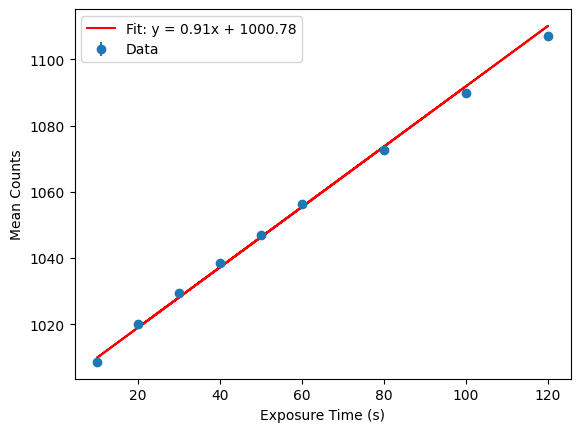

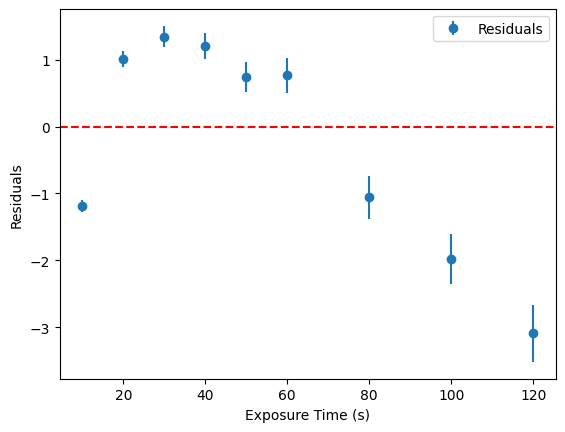

Calculated mean of the bias frames: 1003.60
averaged dark frame mean [1089.87830639 1008.69760799 1106.98442459 1020.00199699 1029.44412804
 1038.41212845 1047.05791283 1056.19071388 1072.58418083]
Estimated Dark Current: 1.6844585390547147 electrons/pixel/second
Standard Deviation of Dark Current: 0.11115527655193663 electrons/pixel/second
Calculated mean of the bias frames: 1061.67
averaged dark frame mean [1998.99380302]
Estimated Dark Current at 15C: 16.01263925830523 electrons/pixel/second
Standard Deviation of Dark Current at 15C: 0.0 electrons/pixel/second


In [180]:
def main():
    file_list, exposure_times = create_file_list_2(folder_path)
    pixel_counts_array = load_dark_frames(file_list)
    pixel_counts_array_15C = load_dark_frames(dark_at_15C)
    if pixel_counts_array.size == 0 or pixel_counts_array_15C.size == 0 :
        print("No files were successfully loaded. Please check file paths and file existence.")
        return

    means, uncertainties, min, max = calculate_statistics(frames=pixel_counts_array, low_limit=None, high_limit=None)
    print(f"here is the dark frames at different exposures mean and the uncertainty, and min/max range: {mean}, {uncertainties},{min},{max}")
    means_15C, uncertainties_15C, min_15C, max_15C = calculate_statistics(frames=pixel_counts_array_15C,low_limit=None, high_limit=None)
    print(f"here is the dark frames at 15C mean and the uncertainty, and min/max range: {means_15C}, {uncertainties_15C},{min_15C},{max_15C}")
    
    mean_limited, systematic_uncertainty= calculate_statistics(frames=pixel_counts_array, low_limit=960,high_limit=1040)
    print(f"here is the dark frames systematic uncertainty and limited range mean, {systematic_uncertainty},{mean_limited}")
    # Perform linear regression
    (slope, intercept), (slope_err, intercept_err) = perform_linear_regression(exposure_times, means, uncertainties)

    # Plot results
    plot_mean_vs_exposure(exposure_times, means, uncertainties, slope, intercept)
    plot_residuals(exposure_times, means, uncertainties, slope, intercept)

    # Estimate dark current
    gain = 2.05
    avg_dark_current, std_dark_current = estimate_dark_current(means, exposure_times, gain, bias_at_15C=None)
    print(f"Estimated Dark Current: {avg_dark_current} electrons/pixel/second")
    print(f"Standard Deviation of Dark Current: {std_dark_current} electrons/pixel/second")
    avg_dark_current_15C, std_dark_current_15C = estimate_dark_current(means_15C, exposure_times=120, gain=gain, bias_at_15C=bias_at_15C)
    print(f"Estimated Dark Current at 15C: {avg_dark_current_15C} electrons/pixel/second")
    print(f"Standard Deviation of Dark Current at 15C: {std_dark_current_15C} electrons/pixel/second")

if __name__ == "__main__":
    main()

Main function carries out our calculations calling the defined functions with the appropriate parameters and values, consolidating the processes of calculation. We calculated both systematic and statistical uncertainty, and can observe that our data has very large outliers based on average means when compared to the min and max range of the data for dark frames at different exposure times. The systematic uncertainty dominates the most with much larger values of around 9 pixels versus our very small statistical uncertainties ranging around 0-1 pixels. Observed on average, lower residuals as exposure time increased, as expected as we know that increasing the exposure time generally gives us higher count values and more tightly fit data. We also observe the expected positvely linear relationship between mean counts of the dark current as well as exposure times. with a value of .91 which is close to perfect linearity. Higher exposure means an increase in Signal-to-ratio which would imply higher counts and since our dark current came out to be fortunately small in mangitude, we hope to obtain fairly clear and corrected images after our correction calculations. The dark current came out to 1.68 e-/p/s with a deviation of .11 e-/p/s, after being doubled by the CCD camera gain value, so our dark current is very little as predicted (and hoped). We also notice that when we calculate the dark current for dark frames at higher temperatures, the dark current value shoots up almost 10x higher, this is validated by our assumptions that dark current is highly sensitive to thermal fluctuations and is proved above in our calculations of both, with the 0C dark current of 1.68 e-/p/s, versus the dark current at 15C which is around 16 e-/p/s. 

## 4.3: Flat Frames

In 4.3 we handle the Flat Fields and imaging them. Flat fields are the 3rd type of calibration files that we handled in this experiment. They are images taken at certain exposures of even illumination sources. (one can use the night sky, a flat panel, etc..) For our imaging, we used the dome of the Mt. Stony Brook Observatory to capture our flat fields. They serve as corrections towards our imaging system, taking care of things such as pixel sensitivity, Vignetting (optical darkening of the image as you approach the edges), and dust/dirt. After calculating our flat fields, they can be used to divide our desired image to "flatten" out imaging inconsistencies and variations. Similar to the dark frames, we take 10 of our flat fields at .3 exposure and take the median combine of them, while normalizing it to our expected typical count level of ~24000 counts to become our master flat field. We then can observe this master flat field frame in a imaging system (such as ds9 for our purposes). We can use ds9 to observe the regions of lower and higher counts, and identify where the image is varied due to either dust or vignetting. If we were to place a star in the center of the flat field versus the upper corner, we would expect it decrease in magnitude due to the vignetting effect for optical images that creates darkening in the edging as mentioned above. We will calculate the exact expected dip below. We will also plot a histogram of the master field counts in order to observe any dead pixels from the image. Dead pixels are pixels that return near zero to zero count values irrespective of the light exposure. They can be represented in the histogram by unexpected apparent spikes at lower pixel value ranges. Generally Flat fields should be taken immediately after observations, let alone the same day. This is because they are heavily dependant on current conditions such as lighting and dust which can vary instantaneously, and even the slightest shift can create large irregularities from the observational image. 

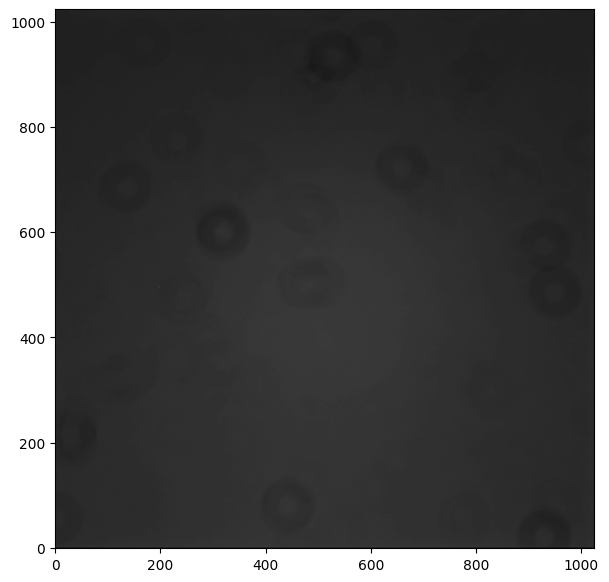

In [181]:
#get list of filepaths to use. Note the unfortunate machine dependence
imaging_flat_path_list = [r"C:\Users\ronan\Group 2 Data\Group 2 Data\Photometry\flats\flat_0.3s_exposure_.0000000" + 
                  str(j) + r".FLAT.FIT" for j in range(10)]

#make + save master flat
master_imaging_flat_array = median_combine(fits_data_to_3d_array(imaging_flat_path_list))
#save_array_as_fits(master_imaging_flat_array,'master_imaging_flat.fits')

#For a preliminary viewing:
fig, ax = plt.subplots(figsize=(7,7))
ax.imshow(master_imaging_flat_array,origin='lower',cmap='gray')

The central bright spot's pixels see about 26200-26400 counts. The darkest large regions are top corners, which receive about 24400-24600 counts per pixel. An apparent superposition of dust rings in the upper middle shows only about 24000 counts per pixel. These faint circles represent the irregularities shown in the flat field due to dust rings and vignetting which we correct by dividing our image by this to remove their apparent effect. The effect of vignetting is apparent as the center is lighter and edges are much darker in comparison in certain areas, especially the corners of the image. 

In [182]:
mflat_ratio = 24500./26300.
mag_change = -2.5*np.log10(mflat_ratio)
print(f"A star's magnitude would change by about {mag_change:.2f} moving from the center to an upper corner.")

A star's magnitude would change by about 0.08 moving from the center to an upper corner.


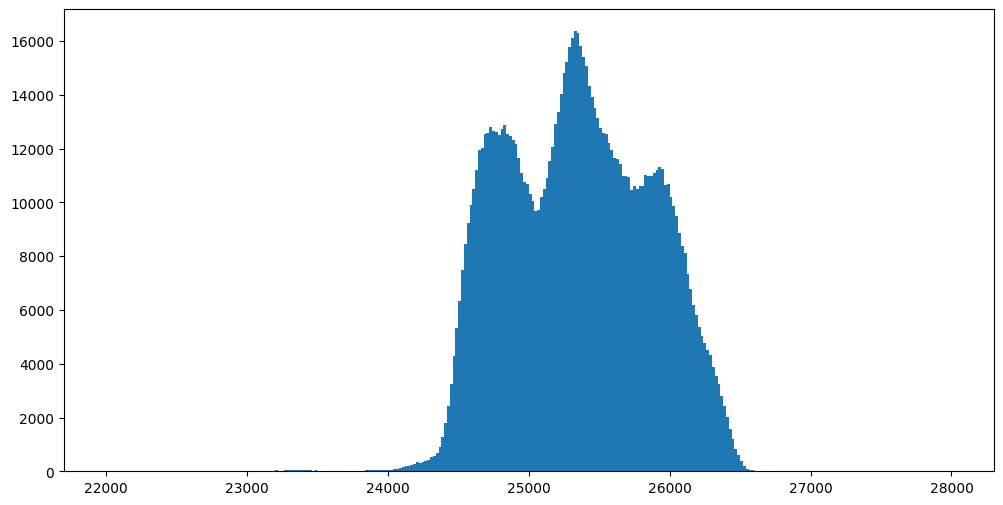

In [183]:
fig, ax = plt.subplots(figsize=(12,6))
plot_hist = ax.hist(master_imaging_flat_array.flatten(),300,[22000,28000])

In [184]:
(master_imaging_flat_array < 18000).sum() #counts how many by adding Trues as 1s. The dead counting method can be revised to reveal their location.

0

As calculated, a star would shift down by about .8 in magnitude due to the vignetting effect of the flat field if placed in the corner versus the center. The histogram shows the distribution of the flat field count values, and it is apparent that the counts are difficult to adapt a gaussian fit. As to why, we can derive it from the ds9 image of the master flat field, we can see the randomized dust rings, along with the gradient in brightness from the center out randomly towards the edges, so it is hard to develop a gaussian fit for the data. As such, using scipy, we were able to develop and roughly gaussian graph, with two lower unexpected peaks most likely created by dust and vignetting. We assume the higher peak is the result of the higher brightness in the center of the image which most definitely has the highest pixel count values, comparable to the highest peak of the graph. As we can see above, there were 0 dead pixels found in graph, which is a positive sign for our instrumentation in that our fields are accurate, and after division, our observational images should be expected to be pretty "pretty". 

## 4.4

4.4 Switches over to the spectroscopic analysis of the experiment, wrapping up the photometric calibration files. It is split up into 7 different subsections, using the flat fields and arc lamp spectrum to ultimately derive where we are in the spectrum of our spectroscopy imaging. In 4.1.1 we will try to identify which of our 3 spectra in our Corrected Flat field image correspond to the $50 \mu m$. Most of our data manipulation will be with the $50 \mu m$ slit, but for reference, there are 2 other slits with widths of $25 \mu m$ and $35 \mu m$. However we expect the spectra corresponding to the 50µm slit to have the highest SNR but lowest resolution, this is because the slit is the widest so more light gets through which increases our signal, but as trade-off, the slit is less biased against multiple wavelengths of light getting through so we experience more blurred spectral features and therefore lower resolution. (*i will detail each subsection as we move along as there are many sections, to avoid large/difficult to read paragraphs*)

In [185]:
#Import FITS File Locations:
flats_file_list = create_file_list(r"C:\Users\ronan\Group 2 Data\Group 2 Data\Spectograph\Flats", 
          file_name = 'spectrograph_flats_20s_', frame_type = '.FLAT', num_of_files= 10, show_list=False)
spectrum_file_list = create_file_list(r"C:\Users\ronan\Group 2 Data\Group 2 Data\Spectograph\lights", 
          file_name = 'spectrograph_lights_20s_', frame_type = '', num_of_files= 10, show_list=False)
darks_file_list = create_file_list(r"C:\Users\ronan\Group 2 Data\Group 2 Data\Spectograph\Darks", 
          file_name = 'spectrograph_darks_20s_', frame_type = '.DARK', num_of_files= 10, show_list=False)
bias_file_list = create_file_list(r"C:\Users\ronan\Group 2 Data\Group 2 Data\Spectograph\Bias", 
          file_name = 'spectrograph_bias_', frame_type = '.BIAS', num_of_files= 10, show_list=False)

#Create FITS Image Data Arrays:
flat_field_array_3d = fits_data_to_3d_array(flats_file_list)
spectrum_array_3d = fits_data_to_3d_array(spectrum_file_list)
darks_array_3d = fits_data_to_3d_array(darks_file_list)
bias_array_3d = fits_data_to_3d_array(bias_file_list)

#Median Combines
flat_field_array_mcombine = median_combine(flat_field_array_3d)
spectrum_array_mcombine = median_combine(spectrum_array_3d)
darks_array_mcombine = median_combine(darks_array_3d)
bias_array_mcombine = median_combine(bias_array_3d)

#Bias Correction
flats_bias_corr = flat_field_array_mcombine - bias_array_mcombine
darks_bias_corr = darks_array_mcombine - bias_array_mcombine
spectrum_bias_corr = spectrum_array_mcombine - bias_array_mcombine  

#Dark Correction  -- These are the arrays that will be utilized now
flat_field_array = flats_bias_corr - darks_bias_corr
spectrum_array = spectrum_bias_corr - darks_bias_corr   

### 4.4.1: Determining Spectra Corresponding to $50 \mu m$ slit
The spectra corresponding to the $50 \mu m$ slit should have the highest signal-to-noise ratio in the flat frames. It should also have the lowest resolution when looking at the spectrum. 

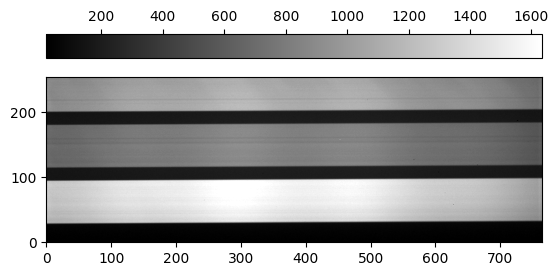

In [186]:
# Display Flat-Field
display_2d_array(flat_field_array)

As we can see, the lower strip appears to comes from the $50 \mu m$ slit. It has the highest signal to noise ratio. When viewing a the spectrum (seen below), you can also see that the lower strip has the lowest resolution (widest) spectral lines.

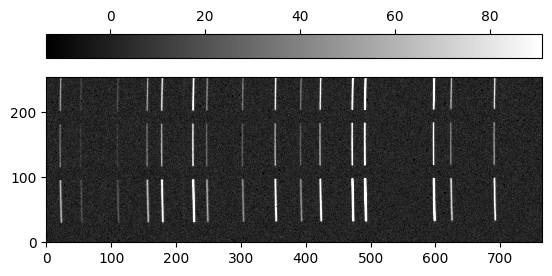

In [187]:
display_2d_array(spectrum_array)

### 4.4.2: Plot 1D Flat-Field Values vs Pixel Position (Along Dispersion Axis)
In 4.2.2 we want to visualize graphically the relationship between the flat field values and pixel locations. In order to execute this, we first will need to truncate our data such that we are only working with the $50 \mu m$ slit spectral data. We can then take the median combine of the flat field data (similar to dark frames median combine) after collapsing our 2D array into a 1D array that has intensity values corresponding to the pixel positions. We can then simply plot these intensities versus our pixel position to graphically visualize the relationship along the *dispersion axis*. The dispersion axis is often the horizontal axis which represents the variation of how the wavelength light is spread out, correspondant to the spectral axis.  

(60, 765)


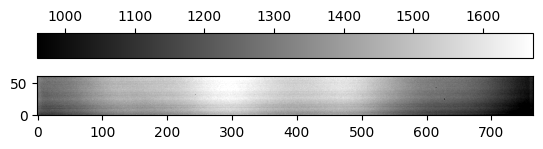

In [188]:
#Step 1

#made a cut in the following range: 34 <= y <= 94
flat_field_cut = cut_images_array(flat_field_array, y_pixel_min=34, y_pixel_max=94)
display_2d_array(flat_field_cut)

#np.savetxt("flat_frame_0.csv", flat_frame_0, delimiter = ",", fmt='%d')
#np.savetxt("flat_frame_0_cut.csv", flat_frame_0_cut, delimiter = ",", fmt='%d')

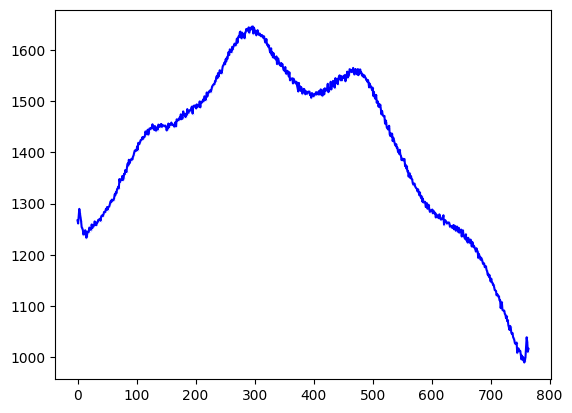

In [189]:
#Find the median of each column and turn into 1D array
flat_field_median = np.median(flat_field_cut, axis=0)
indices = np.arange(len(flat_field_median)) #Create 1d array of indices

#Plot median values vs position
plt.plot(indices, flat_field_median, marker='.', ms=0.1, linestyle='solid', color='blue')

 Here we can see the the plotted graph of our flat field intensity values versus the pixel location. We notice it is not very Gaussian and the graph is very polynomial-like in behavior. This tells us that the flat field values are not uniform across our dispersion axis. But because it is polynomial-like, the variation is smooth enough for us to be able to correct and fit a gaussian to the distribution, which leads us to 4.4.3. 

### 4.4.3: Normalize The Flat Field

In 4.4.3 we will attempt to normalize the flat field to account for the variations of the intensity values, due to either sensitivity or the lamp spectrum itself used for the experiment. We will attempt to fit the distribution to vary around 1 on the axis to remove systematic variations and focus on pixel - pixel sensitivity changes. We can carry this fit out by primarily fitting some lower order polynomial to the 1-D Flat field spectrum. We adapt a lower order polynomial to only capture the larger overall trend while being able to avoid overfitting the distractor/small variations of the field. We then divide our 2D flat-field by this fit, leaving just our smaller scale variations due to the pixel - pixel variations. We can Open this normalized field in Ds9 to compare it to our original field. 

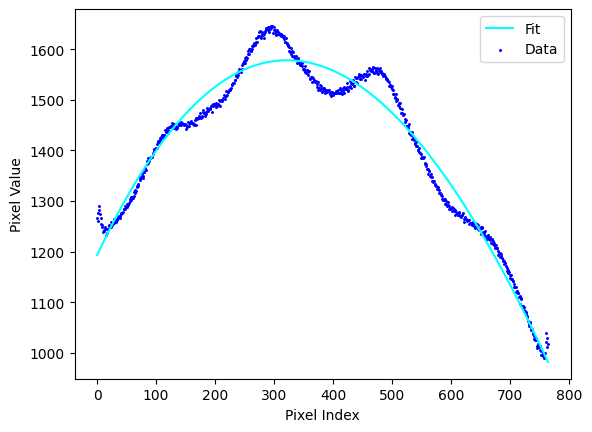

In [190]:
#Fit A Polynomial To The 1D Flat-Field Array Data
coefficients = np.polyfit(indices, flat_field_median, deg=3)

polynomial_fit = np.polyval(coefficients, indices)
polynomial_fit_2d = np.tile(polynomial_fit, (flat_field_cut.shape[0], 1))
normalized_flat_field = flat_field_cut / polynomial_fit_2d

plt.plot(indices, polynomial_fit, color='cyan', label='Fit')
plt.scatter(indices, flat_field_median, color='blue', label='Data', marker='.', s=5)
plt.ylabel('Pixel Value')
plt.xlabel('Pixel Index')
plt.xticks(np.arange(0,801,100))
plt.legend()
#np.savetxt("normalized_flat_field.csv", normalized_flat_field, delimiter = ",", fmt='%d')

Mean: 0.99, Max: 1.12, Min: 0.56


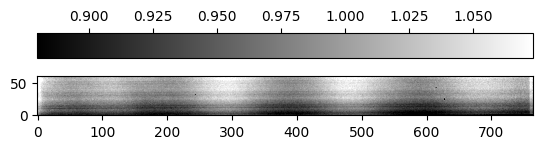

In [191]:
display_2d_array(normalized_flat_field)
print(f'Mean: {np.mean(normalized_flat_field):.2f}, Max: {np.max(normalized_flat_field):.2f}, Min: {np.min(normalized_flat_field):.2f}')

We can see our fitted flat field distributed around a value of 1 along the dispersion axis. We cut out of some of the peaks to hone in on our smaller pixel variations while cutting out the lamp and detector sensitivity variations. Here below is our normalized flat field in Ds9. After normalizing, the variations are much more apparent along the spectrum, represented by the less smooth and more stark changes between the light and dark fields. 

### 4.4.4: Normalize The Arc Lamp Spectrum

In 4.4.4, we will attempt to match the arc lamp spectrum to the normalized flat field by applying the same process of cut out and normalization to the arc lamp spectrum. We will again cut the arc lamp out of the same $50 \mu m$ slit, making the same range cut we did for the flat field image. We can then apply the normalized flat field to this arc lamp spectrum. The purpose of this is to ensure that lamp spectrum is also corrected for the pixel - pixel sensitivity variations, securing that the emission lines of the arc lamp spectrum reflect the proper wavelengths we are working towards. 

(60, 765)


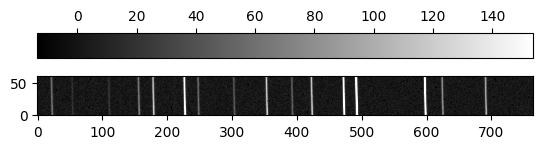

In [192]:
spectrum_array_cut = cut_images_array(spectrum_array, y_pixel_min=34, y_pixel_max=94)
spectrum_normalized = spectrum_array_cut / normalized_flat_field
display_2d_array(spectrum_normalized)

In [193]:
#Normalized Flat-Field to Fit
data_array = normalized_flat_field
hdu = fits.PrimaryHDU(data_array)
hdul = fits.HDUList([hdu])
#hdul.writeto('normalized_flat_field.fit', overwrite=True)

#Normalized Spectrum to Fit
data_array = spectrum_normalized
hdu = fits.PrimaryHDU(data_array)
hdul = fits.HDUList([hdu])
#hdul.writeto('normalized_spectrum.fit', overwrite=True)

As we can see above, after fitting the normalized flat field to the arc lamp spectrum, the emission lines are now clearly visible, as we have cut out the majority of unwanted sensitvity variations excluding the pixel - pixel changes. So the emission lines are now distinct and visible as we have hoped. Now we can proceed to calibrate the wavelengths and compare to the expected range of emission lines within the spectrum we are measuring in, in 4.4.5

### 4.4.5 - Wavelength Calibration

In 4.4.5 we go through the calibration of the wavelengths from the arc lamp spectrum. This can be done by finding the relationship between wavelengths and pixel positions. This will allow us to calculate wavelength from each pixel position, and properly identify our position on the emission spectrum. We will apply a linear best fit to approximate the relationship in linear calculations which will make it easy for us to not only visualize the relationship but also calculate intensities from the pixel positions. 

In [194]:
#Imports and Defninitions
pix_vs_wavelength = pd.read_csv(r"C:\Users\ronan\Downloads\pixels_vs_wavelength.csv")
pix_vs_wavelength['x_index'] = pix_vs_wavelength['x_pixel'] - 1
x_index = pix_vs_wavelength['x_index']
y_data = pix_vs_wavelength['wavelength']
print(pix_vs_wavelength[['x_pixel','wavelength']].head(15))

def linear_function(x,slope,b):
    return slope*x + b

    x_pixel  wavelength
0       112    602.9997
1       158    607.4338
2       180    609.6163
3       228    614.3063
4       249    616.3594
5       304    621.7281
6       355    626.6495
7       424    633.4428
8       474    638.2990
9       493    640.2250
10      599    650.6528
11      626    653.2882
12      693    659.8953


Slope: 0.098, Intercept: 592.065


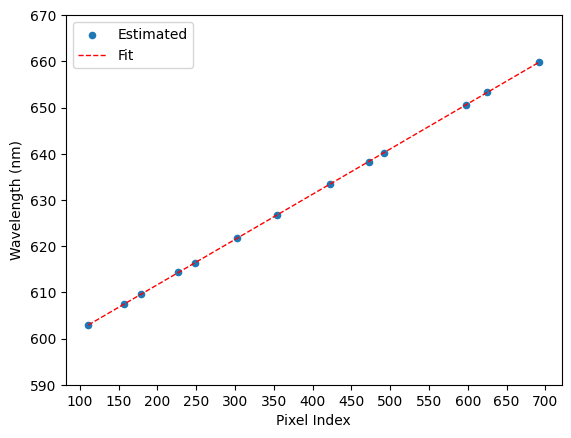

In [195]:
#Find a linear best fit for estimated wavelength to pixel map
slope, intercept = np.polyfit(x_index, y_data, 1)
plt.scatter(x_index, y_data, marker='o', s=20, label='Estimated')
plt.plot(x_index, linear_function(x_index, slope, intercept), color='red', label='Fit', ls='--', lw=1.0)
plt.ylabel('Wavelength (nm)')
plt.xlabel('Pixel Index')
plt.yticks(np.arange(590,671,10))
plt.xticks(np.arange(100,701,50))
plt.legend()
print(f'Slope: {slope:.3f}, Intercept: {intercept:.3f}')

As we can see after plotting the relation, there is a fairly linear relationship of our wavelength as a function of pixel index. This tells us there is uniform dispersion and clear resolution across our spectrum, and that we can confidently match up our wavelengths of our calibrated spectrum against a known emission spectrum to identify where our images are in the physical spectrum line. 

### 4.4.6 Plot Calibrated Spectrum

In 4.4.6 we will plot our calibrated spectrum, identifying the peaks of our Neon spectrum, and then display the ds9 image of our normalized arc lamp spectrum for comparison between the two and identify if we indeed calibrated towards the correct range of the Neon Spectrum Emission lines.

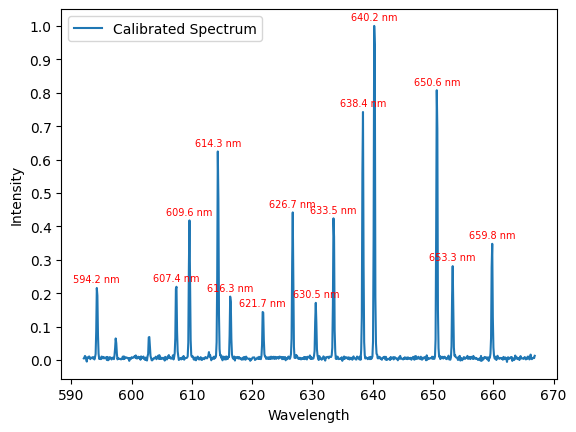

In [196]:
#Normalize the normalized spectrum to have max intensity equal to one 
spectrum_normalized_1d = np.median(spectrum_normalized, axis=0)
factor = 1 / np.max(spectrum_normalized_1d)
spectrum_normalized_1d_scaled = spectrum_normalized_1d * factor

spectrum_index = np.arange(len(spectrum_normalized_1d))
spectrum_wavelength_index = linear_function(spectrum_index, slope, intercept)

#Find Peaks
peaks, _ = find_peaks(spectrum_normalized_1d_scaled, height=0.10)  # Customize height threshold if needed
#print(peaks)
for peak in peaks:
    plt.annotate(f'{spectrum_wavelength_index[peak]:.1f} nm', 
                 (spectrum_wavelength_index[peak], spectrum_normalized_1d_scaled[peak]), 
                 xytext=(0, 4), textcoords='offset points', ha='center', fontsize=7, color='red')

plt.plot(spectrum_wavelength_index, spectrum_normalized_1d_scaled, label='Calibrated Spectrum')
plt.ylabel('Intensity')
plt.xlabel('Wavelength')
plt.yticks(np.arange(0.0,1.1,0.1))
plt.legend(loc='upper left')

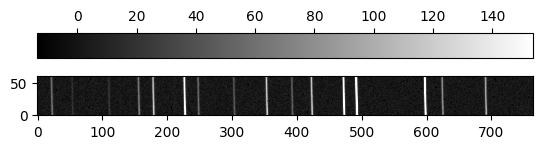

In [197]:
display_2d_array(spectrum_normalized)

As we can see above after the comparison of both images, We indeed have succesfuly calibrated our wavelengthes such that the spectrum has matched up with the emission lines of the neon spectrum along with 500-700 nm wavelength range. 

## 4.4.7

In 4.4.7 we calculate the length and dispersion of the spectrum that is coeverd by our spectrograph 

In [198]:
spectrum_length_nm = spectrum_wavelength_index[-1]-spectrum_wavelength_index[0]
print(f'The length of the spectrum is {(10.0 * spectrum_length_nm):.3f} Angstroms')
print(f'The dispersion of the spectrograph is {(10.0*spectrum_length_nm)/(len(spectrum_index)):.3f} Angstroms/Pixel')

The length of the spectrum is 748.123 Angstroms
The dispersion of the spectrograph is 0.978 Angstroms/Pixel


## 4.5

Bias frames must be subtracted from flats and possibly darks and raw data.

Dark frames must be subtracted from raw data. This subtraction may also subtract bias frames, if they were not subtracted from the darks already.

Flat frames represent the effective sensitivity of the pixels, and must be divided after bias is subtracted.

Ideally, all calibration is done on the same day as the data. If the camera can control its temperature largely independent of local conditions, Bias and Dark frames become largely condition-independent, unless more pixels become hot since the camera was last used, so typically they can be taken later. Flat frames are more strongly dependent on current conditions, since they involve images of the world outside the camera. 

## 4.6

*Our pretty picture has not been taken yet, Our observation day for Lab 1 did not permit it because of cloudy weather, our originally selected 3 days (including backup) all turned out to be cloudy (the week of 9/23-9/27). We are schedulingfor exoplanet lab next week, and hope to finally get a pretty picture :). Sorry for the delay!*

## Conclusion
As we can see, we were able to succesfully calibrate both our photometric and spectroscopic images and resulting data such that we were able to identify the proper range of the Neon Spectrum that we were in. This lab also highlights the importance of calibration data that is important in correction when taking astronomical observations through the use of a telescope and CCD camera. The 3 main calibration files we worked were the Bias frames, Dark frames, and Flat fields. We were able to use our Bias and Dark frames as correction for our Flat fields, and then use our flat fields calculate the spectrum of our arc lamp that we used during experimentation. 